In [2]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential


os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [3]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_10724\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_10724\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_10724\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [4]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [5]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [6]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

KeyboardInterrupt: 

In [ ]:
data = data.dropna()

In [ ]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color='red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()


In [ ]:
def custom_train_test(train, test, steps):
    X_train, y_train, X_test, y_test = [], [], [], [] 
    for i in range(steps, len(train)):
        X_train.append(train[i-steps:i])
        y_train.append(train[i])

    for i in range(steps, len(test)):
        X_test.append(test[i-steps:i])
        y_test.append(test[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_test, y_test


n_train = 35064
n_test = int(len(data)-n_train)
window_size = 24

features = ['total_aggregated']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)

# Define window size for input data

train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

X_train, y_train, X_test, y_test = custom_train_test(train_data, test_data, 2)

In [ ]:
truth = feature_array[-len(y_test):]

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

In [ ]:
history_X = X_train.copy()
history_y = y_train.copy()

In [ ]:
input_shape1 = X_train.shape[-2:]
input_shape1

(2, 1)

In [ ]:
n_forecast_steps = 24  # This could be 1 if you want to predict one step at a time
window = 24*365*3

In [ ]:
# Define the CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=input_shape1))
cnn.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(1))
cnn.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2, 3)              6         
                                                                 
 dropout_7 (Dropout)         (None, 2, 3)              0         
                                                                 
 conv1d_13 (Conv1D)          (None, 2, 3)              12        
                                                                 
 dropout_8 (Dropout)         (None, 2, 3)              0         
                                                                 
 flatten_6 (Flatten)         (None, 6)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable pa

In [39]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions = [] # LISTA DELLE PREVISIONI
errors = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    cnn.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = cnn.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors.append(rmse)
    predictions.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

training and predicting for period 1
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1139.7625209263392
training and predicting for period 2
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 229.97998046875
training and predicting for period 3
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 293.53912062872024
training and predicting for period 4
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 593.0252859933036
training and predicting for period 5
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 515.303466796875
training and predicting for period 6
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 383.3795921688988
training and predicting for period 7
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 447.62350027901783
training and predicting for period 8
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 448.930652

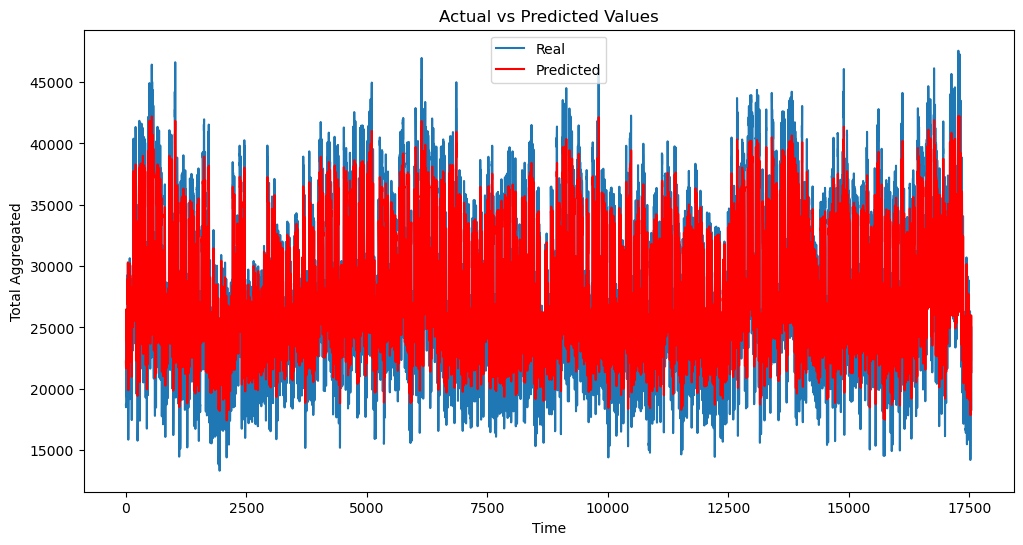

In [40]:
## Plot the actual and predicted values
plot_preds_vs_actual(truth, predictions)
rmse = sqrt(np.mean((truth - predictions)**2))

In [41]:
res = pd.DataFrame(pd.Series(truth.flatten()), columns=['y_true'])
res['y_pred'] = predictions

In [42]:
emse = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Mean Squared Error:', rmse)

Mean Squared Error: 2853.734056305089


In [146]:
#energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste','wind','total_aggregated', 'hydro_tot', 'gas_tot']

## Forecast With saturday and sunday dummies

In [46]:
def create_timestamps(vector, window_size):
    X, Y = [], []
    for i in range(window_size, len(vector)):
        X.append(vector[i-window_size:i, :])
        Y.append(vector[i, 0])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [47]:
features = ['total_aggregated', 'saturday', 'sunday']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
#scaled_array = target_scaler.transform(feature_array)

scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

In [64]:
# Define window size for input data
train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

#train_data = feature_array[:n_train]
#test_data = feature_array[len(train_data):]

## Prepare training data
#X_train, y_train = [], []
#for i in range(window_size, len(train_data)):
#    X_train.append(train_data[i-window_size:i, :])
#    y_train.append(train_data[i, 0])
#X_train, y_train = np.array(X_train), np.array(y_train)
#
## Prepare test data
#X_test, y_test = [], []
#for i in range(window_size, len(test_data)):
#    X_test.append(test_data[i-window_size:i, :])
#    y_test.append(test_data[i, 0])
#X_test, y_test = np.array(X_test), np.array(y_test)

X_train, y_train = create_timestamps(train_data, 2)
X_test, y_test = create_timestamps(test_data, 2)

In [94]:
# Define the CNN model
cnn2 = Sequential()
cnn2.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn2.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
#cnn2.add(MaxPooling1D(pool_size=2))
cnn2.add(Flatten())
#cnn2.add(Dense(1, activation='relu'))
cnn2.add(Dense(1))

cnn2.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 2, 16)             64        
                                                                 
 dropout_38 (Dropout)        (None, 2, 16)             0         
                                                                 
 conv1d_49 (Conv1D)          (None, 2, 16)             272       
                                                                 
 dropout_39 (Dropout)        (None, 2, 16)             0         
                                                                 
 flatten_21 (Flatten)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
 dense_36 (Dense)            (None, 1)               

In [95]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions2 = [] # LISTA DELLE PREVISIONI
errors2 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    cnn2.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = cnn2.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors2.append(rmse)
    predictions2.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

training and predicting for period 1
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 68.69818405877976
training and predicting for period 2
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 642.1229654947916
training and predicting for period 3
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 405.3964611235119
training and predicting for period 4
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 675.6406017485119
training and predicting for period 5
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 449.1882556733631
training and predicting for period 6
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 23.615129743303573
training and predicting for period 7
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 517.4757370721726
training and predicting for period 8
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1050.7705

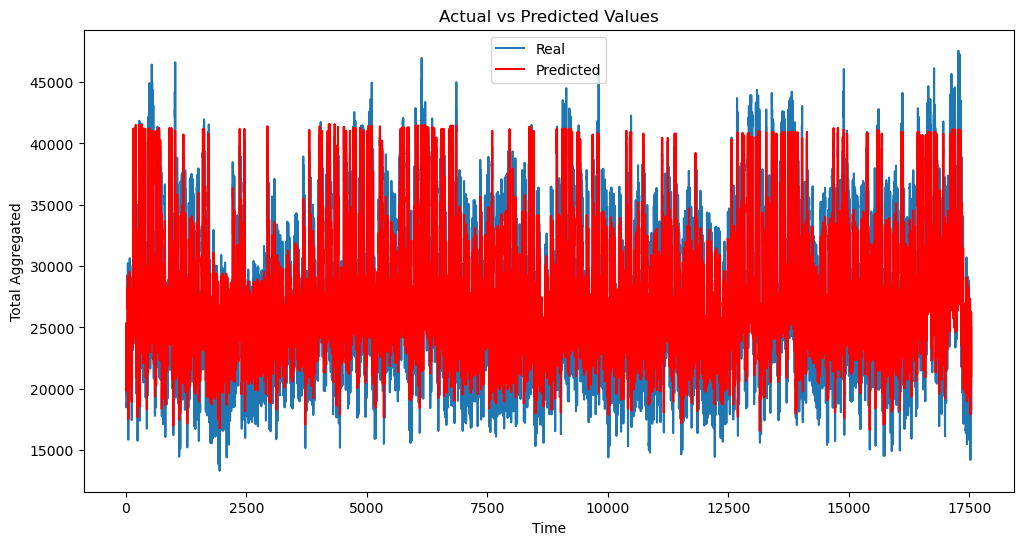

In [96]:
plot_preds_vs_actual(truth, predictions2)

In [97]:
rmse2 = sqrt(np.mean((truth - predictions2)**2))

print('Mean Squared Error:', rmse2)

#mse_inv = sqrt(np.mean((y_pred_inv - y_test_inv)**2))
#print('Mean Squared Error:', mse_inv)

Mean Squared Error: 2392.551734068019


# With business hour dummy

In [98]:
features = ['total_aggregated', 'business hour']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
#scaled_array = target_scaler.transform(feature_array)

scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()
# Define window size for input data
train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

#train_data = feature_array[:n_train]
#test_data = feature_array[len(train_data):]

# Prepare training data
#X_train, y_train = [], []
#for i in range(window_size, len(train_data)):
#    X_train.append(train_data[i-window_size:i, :])
#    y_train.append(train_data[i, 0])
#X_train, y_train = np.array(X_train), np.array(y_train)
#
## Prepare test data
#X_test, y_test = [], []
#for i in range(window_size, len(test_data)):
#    X_test.append(test_data[i-window_size:i, :])
#    y_test.append(test_data[i, 0])
#X_test, y_test = np.array(X_test), np.array(y_test)
X_train, y_train = create_timestamps(train_data, 2)
X_test, y_test = create_timestamps(test_data, 2)

In [300]:
# Define the CNN model
cnn3 = Sequential()
cnn3.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn3.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
cnn3.add(Flatten())
cnn3.add(Dense(1))
cnn3.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn3.summary()

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_248 (Conv1D)         (None, 2, 1)              3         
                                                                 
 conv1d_249 (Conv1D)         (None, 2, 2)              4         
                                                                 
 conv1d_250 (Conv1D)         (None, 2, 2)              6         
                                                                 
 flatten_121 (Flatten)       (None, 4)                 0         
                                                                 
 dense_153 (Dense)           (None, 1)                 5         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [1]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions3 = [] # LISTA DELLE PREVISIONI
errors3 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    cnn3.fit(history_X, history_y, epochs=100, verbose=0, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = cnn3.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors3.append(rmse)
    predictions3.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

NameError: name 'X_train' is not defined

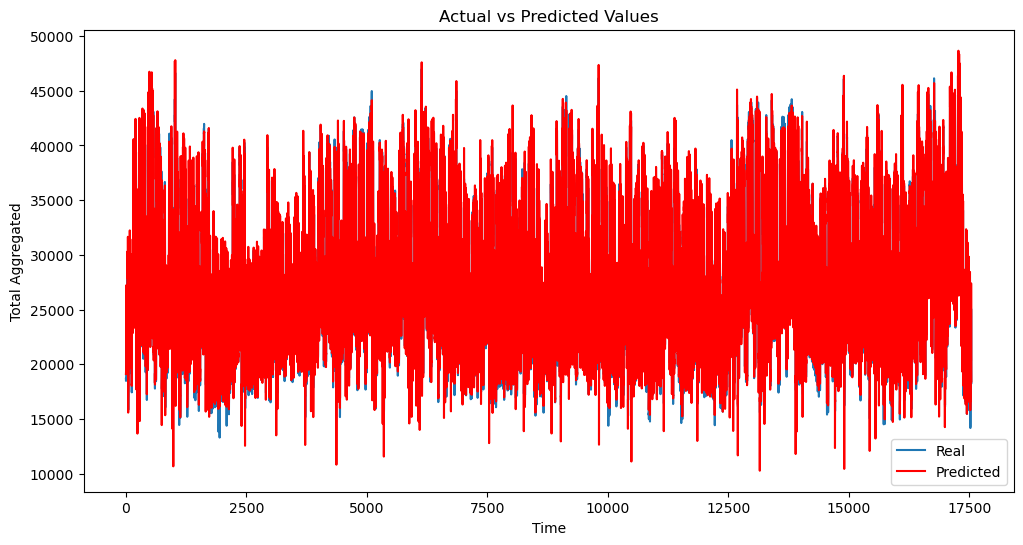

1392.2344276544352


In [ ]:
plot_preds_vs_actual(truth, predictions3)
rmse3 = sqrt(np.mean((truth - predictions3)**2))
print(rmse3)

In [160]:
#mse = sqrt(np.mean((y_pred3 - y_test)**2))
#print('Mean Squared Error:', mse)
#
##mse_inv = sqrt(np.mean((y_pred_inv - y_test_inv)**2))
##print('Mean Squared Error:', mse_inv)

In [109]:
res = pd.DataFrame(predictions3, columns=['y_pred3'])
res['y_pred'] = predictions
res['y_pred2'] = predictions2
res['y_true'] = pd.Series(truth.flatten())

In [110]:
rmse1 = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Root Mean Squared Error just TS:', rmse1)
rmse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Root Mean Squared Error WE dummies:', rmse2)
rmse3 = sqrt(np.mean((res.y_true - res.y_pred3)**2))
print('Root Mean Squared Error BH dummy:', rmse3)

Root Mean Squared Error just TS: 2853.732555794253
Root Mean Squared Error WE dummies: 2392.550103968567
Root Mean Squared Error BH dummy: 1359.4945440041993
